In [1]:
#miray_kaptan_58922

In [2]:
import cv2
from glob import glob
import numpy as np
from matplotlib import pyplot as plt
import math
import pandas as pd

ScaleTo = 70  
seed = 7  

path = 'Plant Seedlings Classification/train/*/*.png' 
files = glob(path)

trainImg = []
trainLabel = []
j = 1
num = len(files)

for img in files:
    print(str(j) + "/" + str(num), end="\r")
    trainImg.append(cv2.resize(cv2.imread(img), (ScaleTo, ScaleTo)))
    trainLabel.append(img.split('/')[-2])  
    j += 1

trainImg = np.asarray(trainImg) 
trainLabel = pd.DataFrame(trainLabel)  

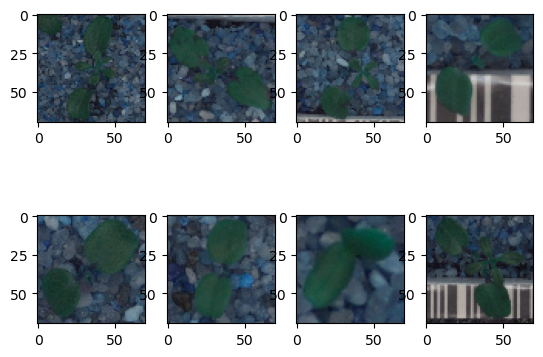

In [3]:
for i in range(8):
    plt.subplot(2, 4, i + 1)
    plt.imshow(trainImg[i])

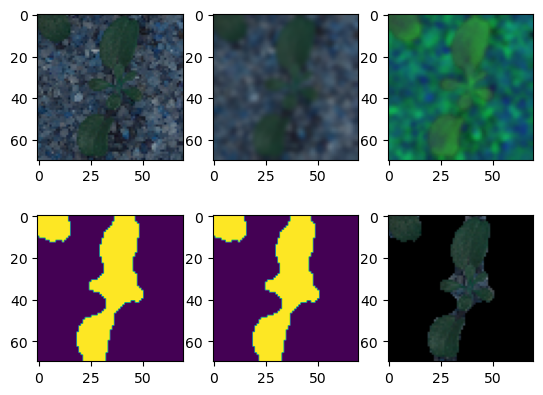

In [4]:
clearTrainImg = []
examples = []; getEx = True
for img in trainImg:
    blurImg = cv2.GaussianBlur(img, (5, 5), 0)   
    
    hsvImg = cv2.cvtColor(blurImg, cv2.COLOR_BGR2HSV)  
    
    lower_green = (25, 40, 50)
    upper_green = (75, 255, 255)
    mask = cv2.inRange(hsvImg, lower_green, upper_green)  
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11, 11))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    
    bMask = mask > 0  
    
    clear = np.zeros_like(img, np.uint8)  
    clear[bMask] = img[bMask] 
    
    clearTrainImg.append(clear)  
    
    if getEx:
        plt.subplot(2, 3, 1); plt.imshow(img)  
        plt.subplot(2, 3, 2); plt.imshow(blurImg)  
        plt.subplot(2, 3, 3); plt.imshow(hsvImg)  
        plt.subplot(2, 3, 4); plt.imshow(mask) 
        plt.subplot(2, 3, 5); plt.imshow(bMask)  
        plt.subplot(2, 3, 6); plt.imshow(clear) 
        getEx = False

clearTrainImg = np.asarray(clearTrainImg)

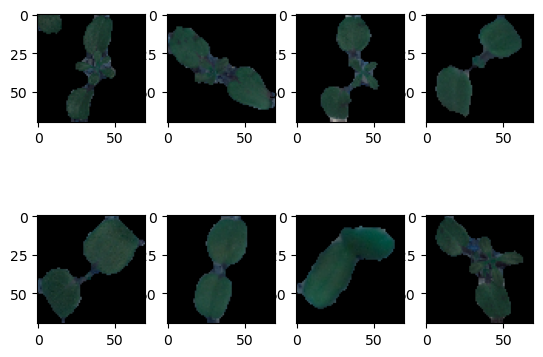

In [5]:
for i in range(8):
    plt.subplot(2, 4, i + 1)
    plt.imshow(clearTrainImg[i])

In [6]:
clearTrainImg = clearTrainImg / 255

In [7]:
print(trainLabel)

             0
0     Cleavers
1     Cleavers
2     Cleavers
3     Cleavers
4     Cleavers
...        ...
4745     Maize
4746     Maize
4747     Maize
4748     Maize
4749     Maize

[4750 rows x 1 columns]


Classes: ['Black-grass' 'Charlock' 'Cleavers' 'Common Chickweed' 'Common wheat'
 'Fat Hen' 'Loose Silky-bent' 'Maize' 'Scentless Mayweed'
 'Shepherds Purse' 'Small-flowered Cranesbill' 'Sugar beet']
Number of classes: 12


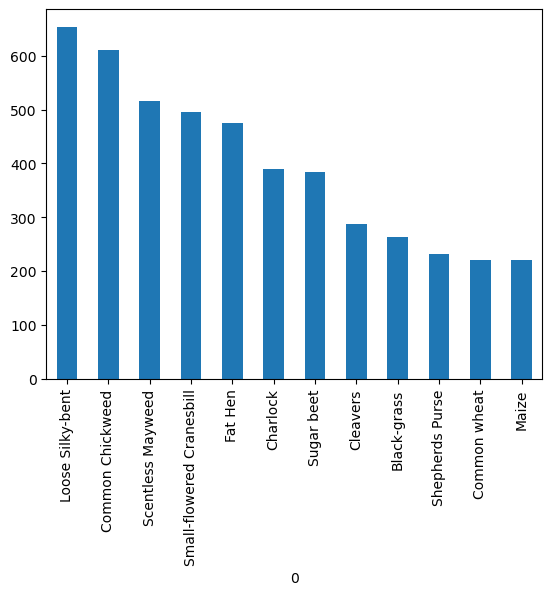

In [8]:
from tensorflow.keras.utils import to_categorical  
from sklearn import preprocessing
import matplotlib.pyplot as plt
import pandas as pd

le = preprocessing.LabelEncoder()
le.fit(trainLabel.iloc[:, 0])  
print("Classes: " + str(le.classes_))
encodeTrainLabels = le.transform(trainLabel.iloc[:, 0]) 

clearTrainLabel = to_categorical(encodeTrainLabels) 
num_classes = clearTrainLabel.shape[1]
print("Number of classes: " + str(num_classes))

trainLabel.iloc[:, 0].value_counts().plot(kind='bar')  
plt.show()

In [9]:
from sklearn.model_selection import train_test_split

print(clearTrainLabel.shape) 

trainX, testX, trainY, testY = train_test_split(clearTrainImg, clearTrainLabel, 
                                                test_size=0.1, random_state=seed, 
                                                stratify=clearTrainLabel)

print(f'trainX shape: {trainX.shape}, testX shape: {testX.shape}')
print(f'trainY shape: {trainY.shape}, testY shape: {testY.shape}')

(4750, 12)
trainX shape: (4275, 70, 70, 3), testX shape: (475, 70, 70, 3)
trainY shape: (4275, 12), testY shape: (475, 12)


In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=180,  # randomly rotate images in the range
    zoom_range=0.1,      # randomly zoom image 
    width_shift_range=0.1,  # randomly shift images horizontally
    height_shift_range=0.1,  # randomly shift images vertically 
    horizontal_flip=True,  # randomly flip images horizontally
    vertical_flip=True    # randomly flip images vertically
)
datagen.fit(trainX)

In [11]:
import numpy
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Input

numpy.random.seed(seed) 

model = Sequential()

model.add(Conv2D(filters=64, kernel_size=(5, 5), activation='relu', input_shape=(ScaleTo, ScaleTo, 3)))
model.add(BatchNormalization(axis=3))
model.add(Conv2D(filters=64, kernel_size=(5, 5), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization(axis=3))
model.add(Dropout(0.1))

model.add(Conv2D(filters=128, kernel_size=(5, 5), activation='relu'))
model.add(BatchNormalization(axis=3))
model.add(Conv2D(filters=128, kernel_size=(5, 5), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization(axis=3))
model.add(Dropout(0.1))

model.add(Conv2D(filters=256, kernel_size=(5, 5), activation='relu'))
model.add(BatchNormalization(axis=3))
model.add(Conv2D(filters=256, kernel_size=(5, 5), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization(axis=3))
model.add(Dropout(0.1))

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(num_classes, activation='softmax'))

model.summary()

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 66, 66, 64)     │         4,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 66, 66, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 62, 62, 64)     │       102,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 31, 31, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 31, 31, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 31, 31, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 27, 27, 128)    │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 27, 27, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 23, 23, 128)    │       409,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 11, 11, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 11, 11, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 11, 11, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 7, 7, 256)      │       819,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 7, 7, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 3, 3, 256)      │     1,638,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 1, 1, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 1, 1, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1, 1, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 3,320,396 (12.67 MB)

 Trainable params: 3,317,580 (12.66 MB)

 Non-trainable params: 2,816 (11.00 KB)

In [27]:
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint

filepath = "plantrecomodels/weights.best_{epoch:02d}-{val_accuracy:.2f}.keras"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', 
                             verbose=1, save_best_only=True, mode='max')

filepath = "plantrecomodels/weights.last_auto4.keras"
checkpoint_all = ModelCheckpoint(filepath, monitor='val_accuracy', 
                                 verbose=1, save_best_only=False, mode='max')

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                             patience=3,  # Number of epochs with no improvement before reducing LR
                                             verbose=1, 
                                             factor=0.5,  # Reduce LR by this factor
                                             min_lr=1e-6)  # Minimum learning rate

callbacks_list = [checkpoint, learning_rate_reduction, checkpoint_all]

hist = model.fit(datagen.flow(trainX, trainY, batch_size=75), 
                 epochs=35, validation_data=(testX, testY), 
                 steps_per_epoch=trainX.shape[0] // 75,
                 callbacks=callbacks_list)


Epoch 1/35
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8672 - loss: 0.3692
Epoch 1: val_accuracy improved from -inf to 0.89684, saving model to plantrecomodels/weights.best_01-0.90.keras

Epoch 1: saving model to plantrecomodels/weights.last_auto4.keras
57/57 ━━━━━━━━━━━━━━━━━━━━ 230s 4s/step - accuracy: 0.8673 - loss: 0.3692 - val_accuracy: 0.8968 - val_loss: 0.2726 - learning_rate: 1.5625e-05
Epoch 2/35
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8750 - loss: 0.3523
Epoch 2: val_accuracy improved from 0.89684 to 0.89895, saving model to plantrecomodels/weights.best_02-0.90.keras

Epoch 2: saving model to plantrecomodels/weights.last_auto4.keras
57/57 ━━━━━━━━━━━━━━━━━━━━ 208s 4s/step - accuracy: 0.8749 - loss: 0.3526 - val_accuracy: 0.8989 - val_loss: 0.2865 - learning_rate: 1.5625e-05
Epoch 3/35
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8729 - loss: 0.3497
Epoch 3: val_accuracy improved from 0.89895 to 0.90947, saving model to plantrecomodels/weights.best_0

In [28]:
model.load_weights("plantrecomodels/weights.best_17-0.96.hdf5")

data = np.load("plantrecomodels/Data.npz")
d = dict(zip(("trainX","testX","trainY", "testY"), (data[k] for k in data)))
trainX = d['trainX']
testX = d['testX']
trainY = d['trainY']
testY = d['testY']

print(model.evaluate(trainX, trainY)) 
print(model.evaluate(testX, testY))  

134/134 ━━━━━━━━━━━━━━━━━━━━ 60s 451ms/step - accuracy: 0.9991 - loss: 0.0014
[0.0014230924425646663, 0.999532163143158]
15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 420ms/step - accuracy: 0.9748 - loss: 0.1862
[0.2750242352485657, 0.9621052742004395]


15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 449ms/step


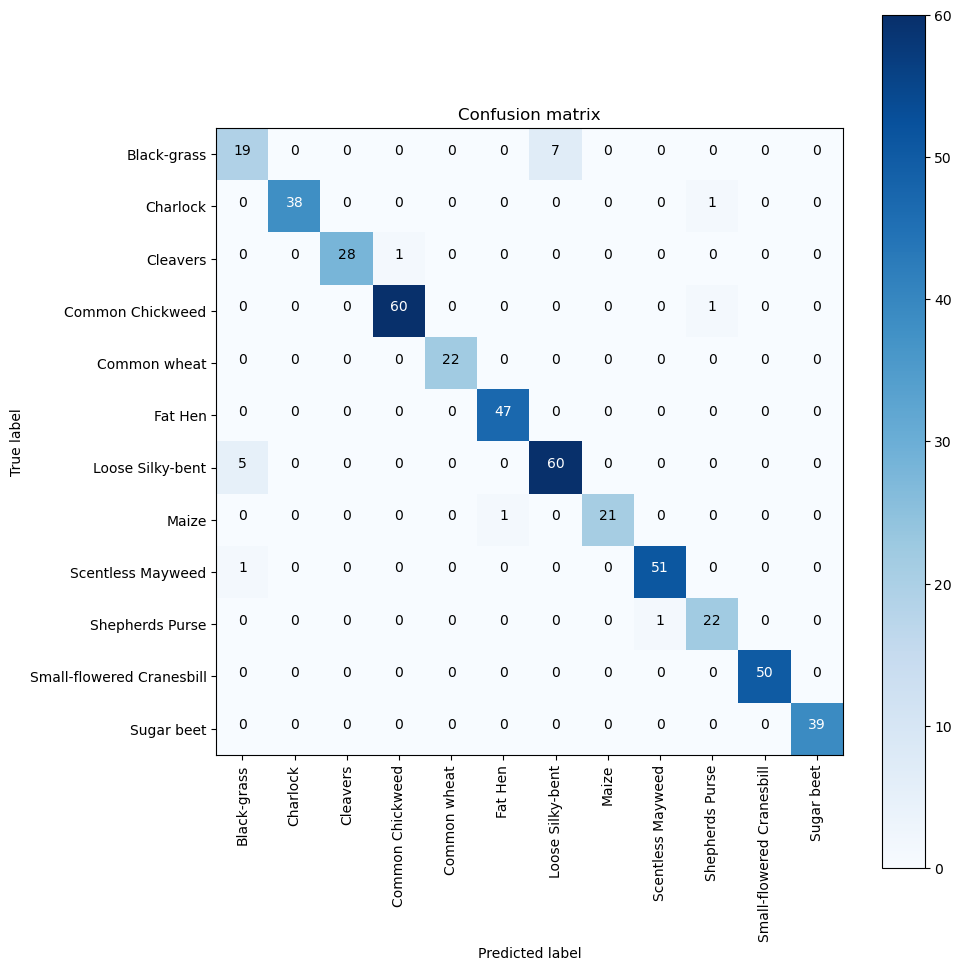

In [29]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    fig = plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

predY = model.predict(testX)
predYClasses = np.argmax(predY, axis = 1) 
trueY = np.argmax(testY, axis = 1) 

confusionMTX = confusion_matrix(trueY, predYClasses) 

plot_confusion_matrix(confusionMTX, classes = le.classes_) 

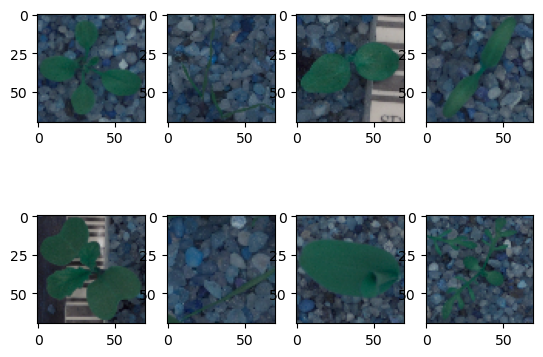

In [30]:
path = 'Plant Seedlings Classification/test/*.png'
files = glob(path)

testImg = []
testId = []
j = 1
num = len(files)

for img in files:
    print("Obtain images: " + str(j) + "/" + str(num), end='\r')
    testId.append(img.split('/')[-1])  
    testImg.append(cv2.resize(cv2.imread(img), (ScaleTo, ScaleTo)))
    j += 1

testImg = np.asarray(testImg) 

for i in range(8):
    plt.subplot(2, 4, i + 1)
    plt.imshow(testImg[i])

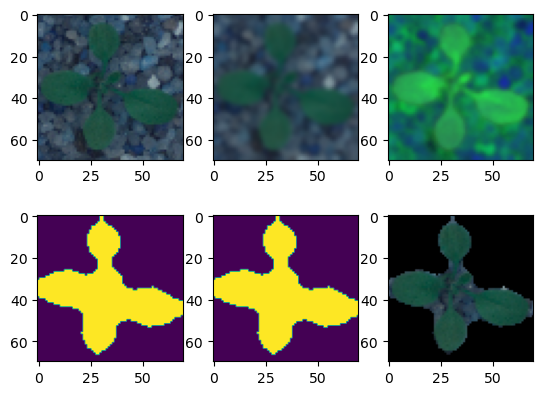

In [31]:
clearTestImg = []
examples = []; getEx = True
for img in testImg:
    blurImg = cv2.GaussianBlur(img, (5, 5), 0)   
    
    hsvImg = cv2.cvtColor(blurImg, cv2.COLOR_BGR2HSV)  
    
    lower_green = (25, 40, 50)
    upper_green = (75, 255, 255)
    mask = cv2.inRange(hsvImg, lower_green, upper_green)  
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11, 11))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    
    bMask = mask > 0  
    
    clear = np.zeros_like(img, np.uint8)  
    clear[bMask] = img[bMask]  
    
    clearTestImg.append(clear) 
    
    if getEx:
        plt.subplot(2, 3, 1); plt.imshow(img)  # Show the original image
        plt.subplot(2, 3, 2); plt.imshow(blurImg)  # Blur image
        plt.subplot(2, 3, 3); plt.imshow(hsvImg)  # HSV image
        plt.subplot(2, 3, 4); plt.imshow(mask)  # Mask
        plt.subplot(2, 3, 5); plt.imshow(bMask)  # Boolean mask
        plt.subplot(2, 3, 6); plt.imshow(clear)  # Image without background
        getEx = False

clearTestImg = np.asarray(clearTestImg)

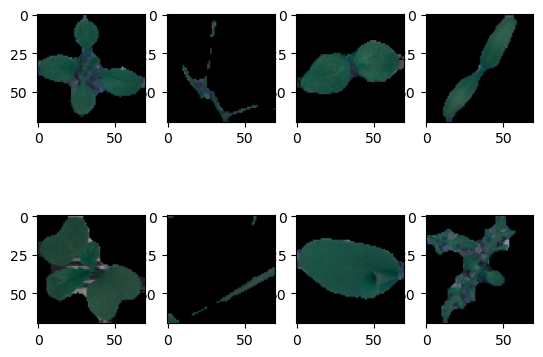

In [32]:
for i in range(8):
    plt.subplot(2, 4, i + 1)
    plt.imshow(clearTestImg[i])

In [33]:
clearTestImg = clearTestImg / 255

In [34]:
pred = model.predict(clearTestImg)

25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 392ms/step


In [35]:
predNum = np.argmax(pred, axis=1)
predStr = le.classes_[predNum]

res = {'file': testId, 'species': predStr}
res = pd.DataFrame(res)
res.to_csv("res.csv", index=False)